<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/feature%2Fpredict_high/High_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке развивается предсказатель высшей точки. Его цель - предсказывать, что мы находимя в локлаьном максимуме - цены выше на заданном горизонте в будущем не будет

In [2]:
#!pip install yfinance

In [3]:
from numpy.core.numeric import isclose
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
%matplotlib inline

In [4]:
from methods import load_data

In [103]:
stocks = load_data("msft", period_start="2021-01-01")
stocks.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,220.224842,220.689974,212.584811,215.434982,37130100
2021-01-05,215.009407,216.256364,213.465569,215.642776,23823000
2021-01-06,209.972127,214.247383,209.744514,210.051300,35930700
2021-01-07,211.822758,217.067858,211.496190,216.028732,27694500
2021-01-08,216.414706,218.295033,214.781804,217.344971,22956200


# Размечаем таргет

In [104]:
def mark_target(prices, window=10, how="high"):
  """Размечаем фактические точки лоу и хай"""
  if how=="high":
    facts = stocks["Close"].rolling(window=window, center=True).max()
  elif how=="low":
    facts = stocks["Close"].rolling(window=window, center=True).min()

  targets = np.zeros_like(prices)
  targets[prices==facts]=1
  return targets

lows = mark_target(stocks["Close"], window=5, how="low")
stocks["lows"] = lows

peaks = mark_target(stocks["Close"], window=5)
stocks["peaks"] = peaks

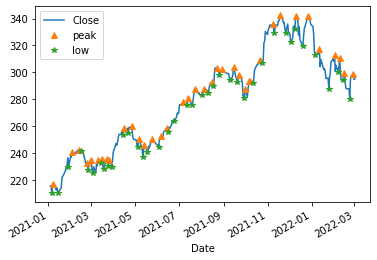

In [105]:
stocks["Close"].plot()
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", label="peak")
stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", label="low")
plt.legend()

# Скользящие средние?

## Расчитываем скользящие средние (СС)

In [106]:
def create_ma(prices, ma_steps=[5,10,15,20]):
  """Фозвращает датафрейм с ценой и её скользящими средними заданной ширины"""
  result=pd.DataFrame()
  result["price"] = prices
  for ma_step in ma_steps:
    ma = prices.rolling(ma_step).mean()
    result["ma_{}".format(ma_step)] = ma
  return result

KeyError: ignored

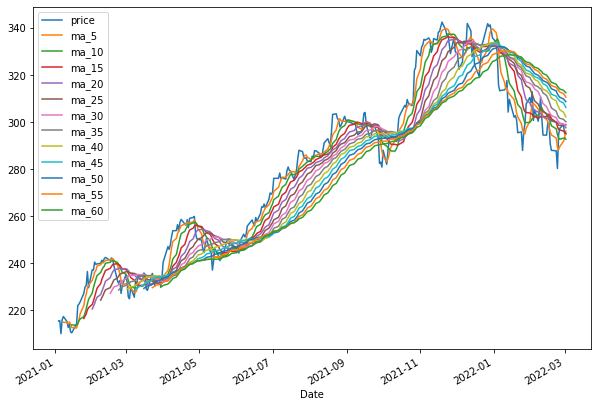

In [107]:
stock_ma = create_ma(stocks["Close"], ma_steps=np.arange(5, 61, 5))
stock_ma.plot(figsize=[10,7])
stocks.loc[stocks["target"]==1, "Close"].plot(style="*")

## Отловим сигналы по СС

In [108]:
def find_sell_signals(short_ma, long_ma):
  """ищем сигнал "продавать" - короткое МА пересекает длинное МА сверху"""
  short_higher = short_ma.shift(-1) > long_ma.shift(-1) #короткое было выше
  short_lower = short_ma.shift(1) < long_ma.shift(1) #короткое стало ниже

  sell_signals = short_higher & short_lower
  return sell_signals

def find_buy_signals(short_ma, long_ma):
  """ищем сигнал "продавать" - короткое МА пересекает длинное МА снизу"""
  short_lower = short_ma.shift(-1) < long_ma.shift(-1) #короткое было выше
  short_higher = short_ma.shift(1) > long_ma.shift(1) #короткое стало ниже

  buy_signals = short_higher & short_lower
  return buy_signals

In [109]:
sell_signals = pd.DataFrame()
buy_signals = pd.DataFrame()

for i in range(1, len(stock_ma.columns)):
  short_ma_name = stock_ma.columns[i]
  short_ma = stock_ma[short_ma_name]
  for j in range(i, len(stock_ma.columns)):
    long_ma_name = stock_ma.columns[j]
    long_ma = stock_ma[long_ma_name]

    sell_signals_name = "{0}_{1}_sell_signal".format(short_ma_name, long_ma_name)
    sell_signals[sell_signals_name] = find_sell_signals(short_ma, long_ma)

    buy_signals_name = "{0}_{1}_buy_signal".format(short_ma_name, long_ma_name)
    buy_signals[buy_signals_name] = find_buy_signals(short_ma, long_ma)

sell_signals= sell_signals.copy().astype(int)
buy_signals= buy_signals.copy().astype(int)

## Выбираем какая пара СС лучше предсказывает пик
пока лучшее, что было придумано - количество пропущенных пиков и рпсстояние до них
TODO: придумать адекватную метрики качества обнаружения пиков

### Отрисовываем

In [110]:
chosen_sell_signals = "ma_5_ma_15_sell_signal"
chosen_buy_signals = "ma_5_ma_15_buy_signal"

In [111]:
stocks["sell_signal"] = np.NaN
stocks.loc[sell_signals[chosen_sell_signals]>0, "sell_signal"] = stocks.loc[sell_signals[chosen_sell_signals]>0, "Close"] 


stocks["buy_signal"] = np.NaN
stocks.loc[buy_signals[chosen_buy_signals]>0, "buy_signal"] = stocks.loc[buy_signals[chosen_buy_signals]>0, "Close"] 

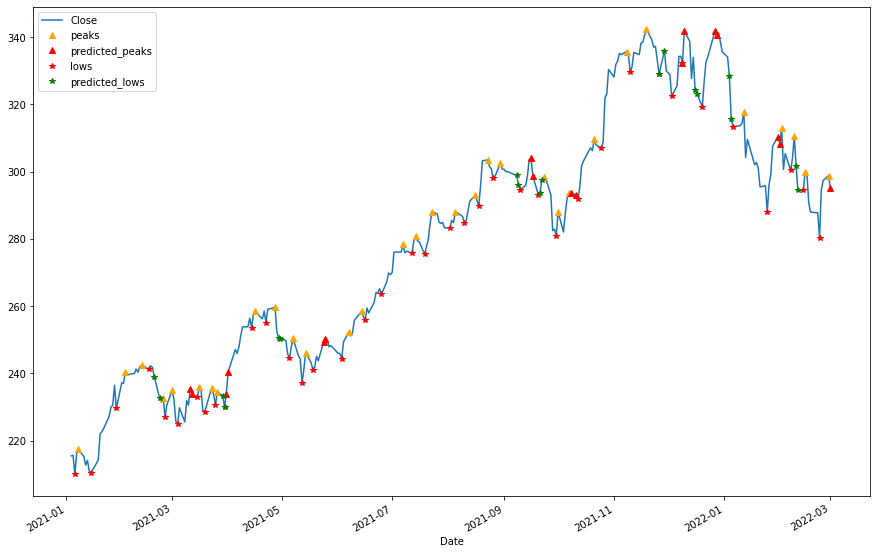

In [112]:
ax = stocks["Close"].plot(figsize=[15,10])
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", color = "orange", label = "peaks")
stocks["sell_signal"].plot(style="^", color = "red", label="predicted_peaks")

stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", color = "red", label = "lows")
stocks["buy_signal"].plot(style="*", color = "green", label="predicted_lows")

ax.legend()

# Валидатор стратегии

In [115]:
#На старте есть 100 уе, играем по стратегии: при сигнале на покупку покупаем всё, при сигнале на продажу - продаём всё

money=1000
eq=0
print("Денег в начале стратегии:", money)

for row in stocks.iterrows():
  r = row[1]

  if ~np.isnan(r["buy_signal"]): #сигнал на покупку
    if money>0: #деньги есть
      price = r["Close"]
      available_eq = np.ceil(money/price)
      eq += available_eq
      money-=available_eq*price
      print("{0}: Покупаем {1}  по цене {2}".format(row[0], available_eq, price))
  if ~np.isnan(r["sell_signal"]): #сигнал на продажу
    if eq>0: #есть что продать
      price = r["Close"]
      sell_eq = eq
      eq = 0
      money+=sell_eq*price
      print("{0}: Продаём {1}  по цене {2}".format(row[0], sell_eq, price))
  #запоминаем последнюю цену
  last_price = r["Close"]

#фиксим прибыль
print("Фиксируемся")
money += last_price * eq 
eq = 0

print("Денег в конце стратегии:", money)

  #print(type(row))
  #print("_______")


Денег в начале стратегии: 1000
2021-02-19 00:00:00: Покупаем 5.0  по цене 239.02305603027344
2021-03-11 00:00:00: Продаём 5.0  по цене 235.21408081054688
2021-03-29 00:00:00: Покупаем 5.0  по цене 233.33935546875
2021-03-31 00:00:00: Продаём 5.0  по цене 233.8650665283203
2021-04-29 00:00:00: Покупаем 4.0  по цене 250.46981811523438
2021-05-24 00:00:00: Продаём 4.0  по цене 249.32818603515625
2021-09-08 00:00:00: Покупаем 4.0  по цене 299.0434265136719
2021-09-16 00:00:00: Продаём 4.0  по цене 304.033935546875
2021-09-21 00:00:00: Покупаем 4.0  по цене 293.6544494628906
2021-10-08 00:00:00: Продаём 4.0  по цене 293.70428466796875
2021-11-26 00:00:00: Покупаем 4.0  по цене 328.9997253417969
2021-12-09 00:00:00: Продаём 4.0  по цене 332.41265869140625
2021-12-16 00:00:00: Покупаем 4.0  по цене 324.2295837402344
2021-12-27 00:00:00: Продаём 4.0  по цене 341.7433776855469
2022-01-04 00:00:00: Покупаем 4.0  по цене 328.33111572265625
2022-01-31 00:00:00: Продаём 4.0  по цене 310.33831787109

# Изменение цены

In [68]:
price_diffs = stocks["Close"].diff()

In [ ]:
price_diffs.mean()

In [ ]:
price_diffs.plot()

In [ ]:
price_diffs.plot(kind="hist", bins=20)

In [ ]:
np.zeros()[prices==maxes]

In [ ]:
t[-10:]

In [ ]:
len(t)

In [ ]:
stocks["Close"]